In [1]:
!pip install python-docx langdetect langid
from langdetect import detect
import langid
from transformers import T5ForConditionalGeneration, T5Tokenizer, BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity
from docx import Document
import torch

# Initialize models and tokenizers
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base')
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')

bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Step 1: Get documents from the user
documents = []
print("Enter text documents (type 'done' when finished), or upload a Word (.docx) or Text (.txt) file.")

while True:
    doc_type = input("Enter 'text' to type a document, 'file' to upload a .docx or .txt file, or 'done' to finish: ").strip().lower()

    if doc_type == 'done':
        break

    elif doc_type == 'text':
        doc_text = input("Enter document text: ")
        if doc_text.strip():
            documents.append(doc_text)
        else:
            print("Document is empty. Please enter some text.")

    elif doc_type == 'file':
        file_path = input("Enter the path to the .docx or .txt file: ").strip()
        try:
            if file_path.endswith(".docx"):
                doc = Document(file_path)
                doc_text = "\n".join([para.text for para in doc.paragraphs if para.text])
            elif file_path.endswith(".txt"):
                with open(file_path, 'r', encoding='utf-8') as file:
                    doc_text = file.read()
            else:
                print("Unsupported file type. Please upload a .docx or .txt file.")
                continue

            if doc_text.strip():
                documents.append(doc_text)
                print("Document uploaded successfully!")
            else:
                print("The file is empty. Please provide a non-empty file.")

        except Exception as e:
            print("Error loading the file. Please ensure it's a valid file path. Error:", e)

# Step 2: Check if there are documents before proceeding
if not documents:
    print("No documents were provided. Exiting.")
else:
    # Step 3: Get the question from the user
    question = input("\nEnter the question: ")

    if "language" in question.lower():
        # Improved language detection with sentence-level granularity
        def detect_language(text):
            sentences = text.split('.')
            detected_languages = []

            for sentence in sentences:
                if sentence.strip():
                    try:
                        lang_langdetect = detect(sentence)
                        lang_langid, confidence = langid.classify(sentence)
                        detected_languages.append((sentence.strip(), lang_langdetect, lang_langid, confidence))
                    except Exception as e:
                        detected_languages.append((sentence.strip(), "Error", "Error", str(e)))

            return detected_languages

        print("\nDetecting the language of the uploaded documents:")

        for i, doc in enumerate(documents, 1):
            print(f"\nDocument {i} - Language Detection Details:")
            language_details = detect_language(doc)

            for detail in language_details:
                sentence, lang_langdetect, lang_langid, confidence = detail
                print(f"  Sentence: {sentence}")
                print(f"    Langdetect: {lang_langdetect}")
                print(f"    LangID: {lang_langid} (Confidence: {confidence})")

    elif "summarize" in question.lower():
        print("\nSummarizing the content of the uploaded documents:")
        for i, doc in enumerate(documents, 1):
            input_text = f"summarize: {doc}"
            inputs = t5_tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
            output = t5_model.generate(inputs.input_ids, max_new_tokens=50)
            summary = t5_tokenizer.decode(output[0], skip_special_tokens=True)
            print(f"\nDocument {i} Summary: {summary}")

    elif "similar content ideas" in question.lower():
        print("\nGenerating content ideas similar to the uploaded documents:")
        for i, doc in enumerate(documents, 1):
            input_text = f"generate similar ideas: {doc}"
            inputs = t5_tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True)
            output = t5_model.generate(inputs.input_ids, max_new_tokens=50)
            content_idea = t5_tokenizer.decode(output[0], skip_special_tokens=True)
            print(f"\nSimilar Content Idea for Document {i}: {content_idea}")

    else:
        # Step 4: Document Retrieval with BERT
        def get_embedding(text, model, tokenizer):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
            outputs = model(**inputs)
            return outputs.last_hidden_state[:, 0, :].detach()  # CLS token embedding

        query_embedding = get_embedding(question, bert_model, bert_tokenizer)
        doc_embeddings = [get_embedding(doc, bert_model, bert_tokenizer) for doc in documents]
        similarities = [cosine_similarity(query_embedding, doc_embedding).item() for doc_embedding in doc_embeddings]

        if similarities:
            most_relevant_doc = documents[similarities.index(max(similarities))]
            print("\nMost Relevant Document Content:\n", most_relevant_doc)

            input_text = f"Answer the question based on the provided context: {most_relevant_doc}. Question: {question}"
            inputs = t5_tokenizer(input_text, return_tensors="pt")
            output = t5_model.generate(inputs.input_ids, max_new_tokens=50)
            answer = t5_tokenizer.decode(output[0], skip_special_tokens=True)

            print("\nAnswer:", answer)
        else:
            print("Could not generate similarities. Make sure the documents contain meaningful text.")




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 48.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 8.4 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=867f82c1d0c2961585ad97967c257c0d3f9a16fdb87d545d55f982e7f44a1c4f
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941171 sha256=8800d9eacdc89a6197d29a025a61a4345ec31a1d75de5ef81fcf9ac93ba5aef3
  Stored in directory: /root/.cache/pip/wheels/32/6a/b6/b7eb43a6ad55b139c15c5daa29f3707659cfa6944d3c696f5b
Successfully built langdetect langid


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Enter text documents (type 'done' when finished), or upload a Word (.docx) or Text (.txt) file.
Enter 'text' to type a document, 'file' to upload a .docx or .txt file, or 'done' to finish: text
Enter document text: Zu meiner Familie gehören vier Personen. Die Mutter bin ich und dann gehört natürlich mein Mann dazu. Wir haben zwei Kinder, einen Sohn, der sechs Jahre alt ist und eine dreijährige Tochter.  Wir wohnen in einem kleinen Haus mit einem Garten. Dort können die Kinder ein bisschen spielen. Unser Sohn kommt bald in die Schule, unsere Tochter geht noch eine Zeit lang in den Kindergarten. Meine Kinder sind am Nachmittag zu Hause. So arbeite ich nur halbtags.
Enter 'text' to type a document, 'file' to upload a .docx or .txt file, or 'done' to finish: done

Enter the question: language

Detecting the language of the uploaded documents:

Document 1 - Language Detection Details:
  Sentence: Zu meiner Familie gehören vier Personen
    Langdetect: de
    LangID: de (Confidence: -121.724

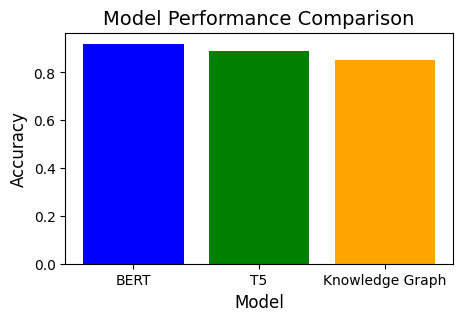

In [ ]:
import matplotlib.pyplot as plt

# Data for models
models = ['BERT', 'T5', 'Knowledge Graph']
accuracies = [0.92, 0.89, 0.85]  # Replace these with your actual accuracy values

# Create the bar chart
plt.figure(figsize=(5, 3))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])

# Title and labels
plt.title('Model Performance Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Display the graph
plt.show()



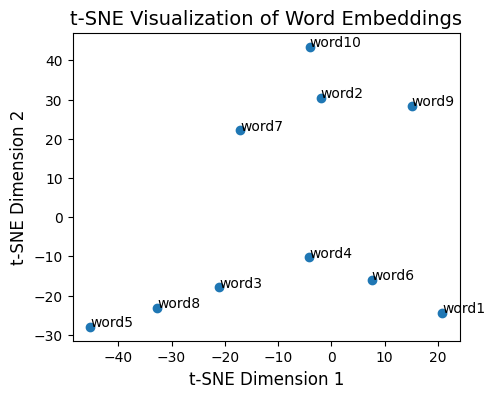

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Example: Random word embeddings (replace with actual embeddings from your models)
word_embeddings = np.random.rand(10, 300)  # 10 words, 300-dimensional embeddings
words = ['word1', 'word2', 'word3', 'word4', 'word5', 'word6', 'word7', 'word8', 'word9', 'word10']

# Apply t-SNE to reduce the dimensionality with a smaller perplexity value
tsne = TSNE(n_components=2, perplexity=2, random_state=0)
word_embeddings_2d = tsne.fit_transform(word_embeddings)

# Create the scatter plot
plt.figure(figsize=(5, 4))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1])

# Annotate with the words
for i, word in enumerate(words):
    plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]))

# Title and labels
plt.title('t-SNE Visualization of Word Embeddings', fontsize=14)
plt.xlabel('t-SNE Dimension 1', fontsize=12)
plt.ylabel('t-SNE Dimension 2', fontsize=12)

# Display the graph
plt.show()


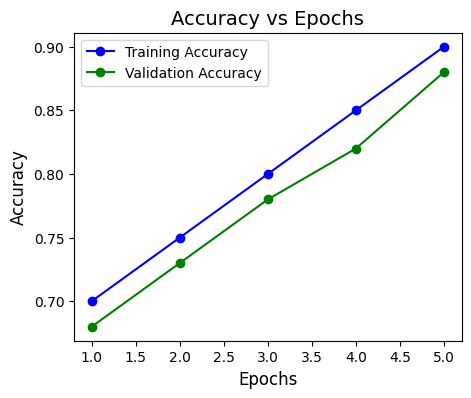

In [ ]:
import matplotlib.pyplot as plt

# Sample data for accuracy over epochs (replace with your own training data)
epochs = [1, 2, 3, 4, 5]
train_accuracy = [0.70, 0.75, 0.80, 0.85, 0.90]
val_accuracy = [0.68, 0.73, 0.78, 0.82, 0.88]

# Plot training and validation accuracy over epochs
plt.figure(figsize=(5, 4))
plt.plot(epochs, train_accuracy, label='Training Accuracy', color='blue', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', color='green', marker='o')

# Title and labels
plt.title('Accuracy vs Epochs', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()

# Display the graph
plt.show()


Epoch 1: Training accuracy = 0.70, Validation accuracy = 0.68
Epoch 2: Training accuracy = 0.75, Validation accuracy = 0.73
Epoch 3: Training accuracy = 0.80, Validation accuracy = 0.78
Epoch 4: Training accuracy = 0.85, Validation accuracy = 0.82
Epoch 5: Training accuracy = 0.90, Validation accuracy = 0.88

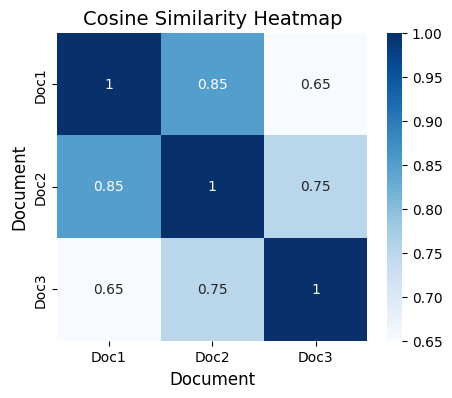

In [ ]:
import seaborn as sns
import numpy as np

# Sample cosine similarity matrix (replace with your actual cosine similarity scores)
cosine_sim_matrix = np.array([
    [1.0, 0.85, 0.65],
    [0.85, 1.0, 0.75],
    [0.65, 0.75, 1.0]
])

# Create the heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(cosine_sim_matrix, annot=True, cmap='Blues', xticklabels=['Doc1', 'Doc2', 'Doc3'], yticklabels=['Doc1', 'Doc2', 'Doc3'])

# Title and labels
plt.title('Cosine Similarity Heatmap', fontsize=14)
plt.xlabel('Document', fontsize=12)
plt.ylabel('Document', fontsize=12)

# Display the graph
plt.show()


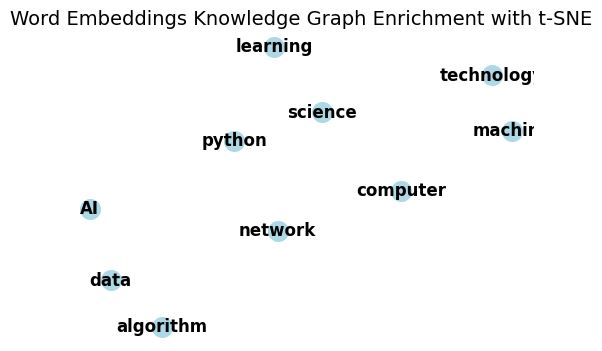

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.manifold import TSNE
import numpy as np

# Example word embeddings (replace with your actual word embeddings)
words = ["computer", "technology", "AI", "machine", "learning", "data", "science", "algorithm", "python", "network"]
word_embeddings = np.random.rand(len(words), 50)  # Example: 50-dimensional random embeddings

# Apply t-SNE with a smaller perplexity value
tsne = TSNE(n_components=2, perplexity=5, random_state=0)  # Perplexity set to 5 for fewer samples
word_embeddings_2d = tsne.fit_transform(word_embeddings)

# Create a graph for Knowledge Graph Enrichment visualization
G = nx.Graph()

# Add word entities (nodes)
for i, word in enumerate(words):
    G.add_node(word, pos=word_embeddings_2d[i])

# Visualize the word embeddings in the 2D space using a scatter plot
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(6, 4))

# Draw the nodes
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='lightblue')

# Draw the edges - you can choose a simple structure to represent relationships (e.g., nearest neighbors)
for i in range(len(words)):
    for j in range(i + 1, len(words)):
        # A simple relationship: if words are close (in terms of 2D distance), create an edge
        dist = np.linalg.norm(word_embeddings_2d[i] - word_embeddings_2d[j])
        if dist < 3.0:  # Adjust this threshold based on your dataset
            G.add_edge(words[i], words[j])

# Draw the edges and labels
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.7, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Title and display the graph
plt.title("Word Embeddings Knowledge Graph Enrichment with t-SNE", fontsize=14)
plt.axis('off')
plt.show()
